## Manually Label Project Metaphors

Randomly select projects and extract potential metaphors. Manually label whether the presented text fragment contains a metaphorical cancer-related phrase. Focus given to the underlined keyword token.

### TODO

o More labeled data

o Cancer as a subject or object. Does cancer fight the patient, or the other way around?

In [1]:
import os.path as op

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import pandas as pd
from sklearn.metrics import precision_score, recall_score

import re

In [2]:
DATA_PROCESSED = '../data/processed'

UNDERLINE = '\033[4m'
END = '\033[0m'

### Load Projects and Labeled Keywords

In [3]:
all_projects = pd.read_csv(op.join(DATA_PROCESSED, 'combined_projects.csv'))

labeled = pd.read_csv(op.join(DATA_PROCESSED, 'labeled.csv'))

print(f'Total Projects DF: {len(all_projects):,}')
print(f'Total Labeled Keywords DF: {len(labeled):,}')
print(f'Total Unique Projects Labeled: {labeled.project_id.nunique():,}')

Total Projects DF: 10,097
Total Labeled Keywords DF: 2,932
Total Unique Projects Labeled: 1,526


### Stats

In [4]:
kickstarter_mask = all_projects['source'] == 'kickstarter'
gofundme_mask = all_projects['source'] == 'gofundme'
print(f'Kickstarter vs. GFM:\t {kickstarter_mask.mean()*100:.2f}% / {gofundme_mask.mean()*100:.2f}%')

ixs = all_projects.loc[kickstarter_mask, 'id'].values
filt = labeled.loc[labeled['project_id'].isin(ixs), 'metaphorical'].dropna()

print(f'Metaphors per Kickstarter project: {len(filt) / len(ixs):.3f}')

ixs = all_projects.loc[gofundme_mask, 'id'].values
filt = labeled.loc[labeled['project_id'].isin(ixs), 'metaphorical'].dropna()

print(f'Metaphors per GFM project: {len(filt) / len(ixs):.3f}')

p_hat = filt.mean()
project_n = labeled.loc[labeled['project_id'].isin(ixs), 'project_id'].nunique()
keyword_n = len(filt)
del ixs, filt

z005 = 2.575829

print()
print(f'Sample proportion of GFM metaphorical keywords:\t {p_hat*100:.2f}%')
print(f'99% CI:\t ({(p_hat - z005 * np.sqrt(p_hat * (1-p_hat) / keyword_n)) * 100:.2f}%, {(p_hat + z005 * np.sqrt(p_hat * (1-p_hat) / keyword_n)) * 100:.2f}%)')
print(f'GFM Projects N={project_n:,}, GFM Keywords N={keyword_n:,}')
print(f'For {p_hat*100:.2f}% +- 1%:\t n > {int(z005**2 * p_hat * (1-p_hat) / 0.01**2):,}')
print(f'For {p_hat*100:.2f}% +- 0.5%:\t n > {int(z005**2 * p_hat * (1-p_hat) / 0.005**2):,}')

Kickstarter vs. GFM:	 4.05% / 95.95%
Metaphors per Kickstarter project: 1.142
Metaphors per GFM project: 0.173

Sample proportion of GFM metaphorical keywords:	 91.06%
99% CI:	 (89.27%, 92.85%)
GFM Projects N=1,118, GFM Keywords N=1,678
For 91.06% +- 1%:	 n > 5,400
For 91.06% +- 0.5%:	 n > 21,603


https://metaphor.icsi.berkeley.edu/pub/en/index.php/Metaphor:CANCER_IS_A_JOURNEY

In [5]:
# these are ordered lists - since we search in order the lemma comes last (so not to catch non-lemma'd words)

BATTLE_WORDS = ['fights', 'fighting', 'fight', 'fought', 'battles', 'battled', 'battling', 'battle', 'war', 'beating', 'beats', 'beaten', 'beat', 'enemy', 'brutal', 'defeat', 'winning', 'win']

JOURNEY_WORDS = ['path', 'journey']

window = 80

# Manually Label Metaphors

In [6]:
def find_keywords(text, source, source_type):
    '''
    Search `text` for all instances of keywords in `source`.
    '''
    if not isinstance(text, float):
        for kw in source:
            exp = r'\W(' + kw + ')\W'
            for kw_match in re.finditer(exp, text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(project.text), kw_match.end() + window)

                prompt = text[start:kw_match.start()+1] + UNDERLINE + text[kw_match.start()+1:kw_match.end()-1] + END + text[kw_match.end()-1:end]

                yield prompt, {'fragment': text[start:end], 
                               'char_location': float(kw_match.start()),
                               'kw_start': int(kw_match.start()) - int(start) + 1,
                               'type': source_type, 
                               'keyword': kw}
            
def is_metaphorical():
    res = input('Is this a cancer related metaphor? ')
    return res == 'y'

def exists_with_keyword(source, ix, char_location):
    '''
    Does the given project, with ID `ix`, exist in `source` with a keyword at `char_location`?
    '''
    return char_location in source.loc[source['project_id'] == ix, 'char_location'].values
    
def exists_without_keywords(source, ix):
    '''
    Does the given project, with ID `ix`, exist in `source` as a null (meaning, it has been seen previously
    and labeled as having no keywords)?
    '''
    locs = source.loc[source['project_id'] == ix, 'char_location']
    return len(locs) == 1 and sum(locs.isnull()) == 1

def max_unlabeled():
    return len(all_projects.loc[~all_projects['id'].isin(labeled['project_id'])])

In [15]:
c = int(input(f'N (max: {int(max_unlabeled()):,}): '))

tp, fp, nan = 0, 0, 0
        
for project in all_projects.sample(frac=1).itertuples():
    
    print()
    print(f'PROJECT {project.name}')
    
    keyword_found = False
    
    for source, key in [(BATTLE_WORDS, 'battle'), (JOURNEY_WORDS, 'journey')]:
        for prompt, result in find_keywords(project.text, source, key):
            
            if exists_with_keyword(labeled, project.id, result['char_location']):
                continue
            
            if exists_without_keywords(labeled, project.id):
                labeled = labeled.loc[labeled['project_id'] != project.id]
                
            c -= 1
            keyword_found = True
            print(prompt)
            result['project_id'] = project.id
            if is_metaphorical():
                result['metaphorical'] = True
                labeled = labeled.append(result, ignore_index=True)                
                tp += 1
            else:
                result['metaphorical'] = False
                labeled = labeled.append(result, ignore_index=True)
                fp += 1
                
    # if no metaphor existed and this isn't already known
    if not keyword_found and not exists_without_keywords(labeled, project.id):
        result = {'project_id': project.id,
                    'fragment': np.nan, 
                    'char_location': np.nan,
                    'kw_start': np.nan,
                    'type': 'none',
                    'metaphorical': np.nan,
                    'keyword': np.nan}
        
        labeled = labeled.append(result, ignore_index=True)  
        nan += 1
        print('No metaphors found')
    
    if c <= 0:
        break

print(f'True Positives: {tp} - False Positives: {fp} - Non-existent: {nan}')

N (max: 8,447): 3

PROJECT Roscoe's Rally Against Cancer
brauer family everyone kept asking “How can we help!” Roscoe Bierbrauer has been fighting kidney cancer that has now metastasized for two years. Roscoe works as a Premier
Is this a cancer related metaphor? y
family, but especially Roscoe has had and continues to have in dealing with this fight for his life. Roscoe truly is a hero and inspires so many people. Both Roscoe an
Is this a cancer related metaphor? y
astasized. We want to help Roscoe and his family to be able to just focus on his battle against cancer and are asking if you can donate and contribute in any way to his
Is this a cancer related metaphor? y
against cancer and are asking if you can donate and contribute in any way to his battle please do so. What would be helpful to this family is prayers, especially prayer
Is this a cancer related metaphor? y
aves of absence from their jobs and are juggling raising their two kids with his battle against cancer. If you can hel

In [16]:
print(labeled.duplicated().sum())
labeled = labeled.drop_duplicates()

0


Total metaphor keywords: 2003


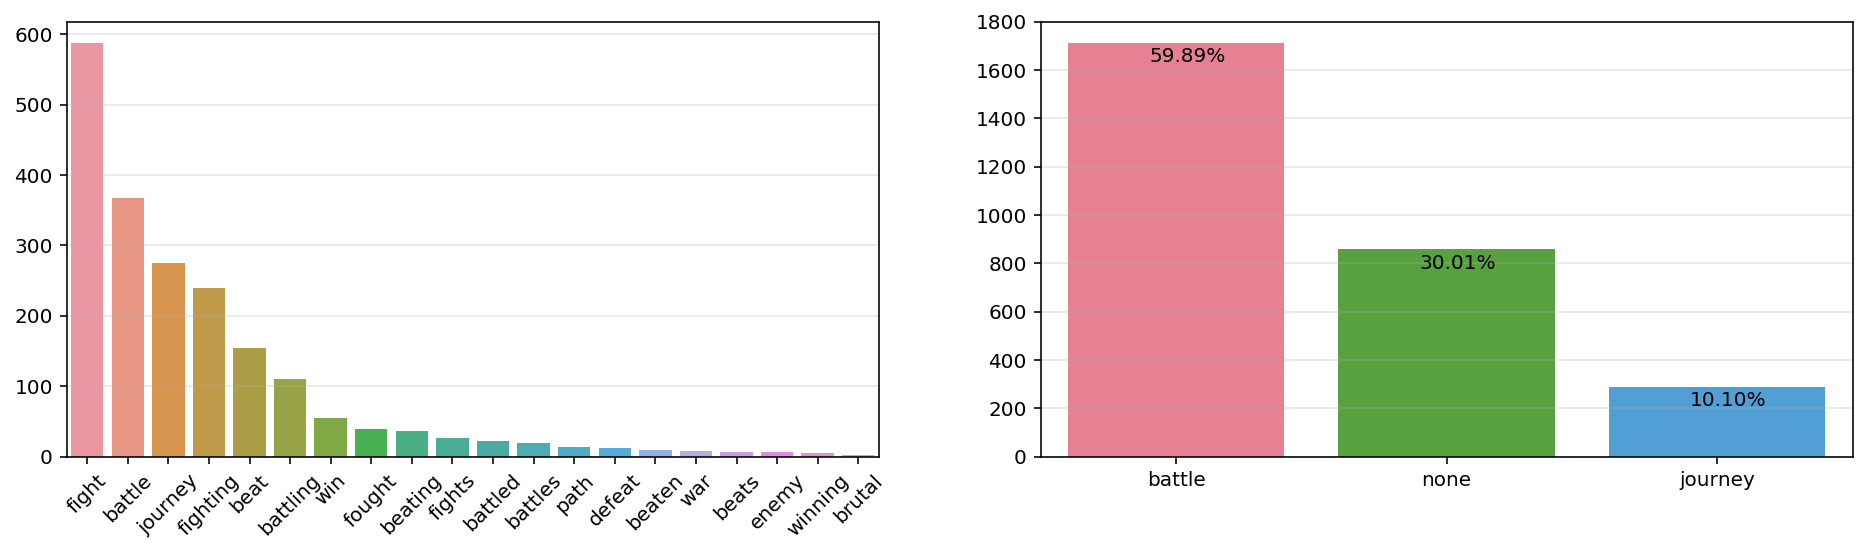

In [17]:
print(f'Total metaphor keywords: {len(labeled.loc[labeled["metaphorical"] == True])}')

plt.subplots(1, 2, figsize=(16,4))

plt.subplot(1,2,1)
vc = labeled.loc[labeled['metaphorical'] == True, 'keyword'].value_counts();
sns.barplot(vc.index, vc.values)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1,2,2)
vc = labeled.loc[labeled['metaphorical'] != False, 'type'].value_counts()
g = sns.barplot(vc.index, vc.values, palette='husl')
plt.grid(axis='y', alpha=0.3)

s = sum(vc.values)
for p in g.patches:
    h = p.get_height()
    plt.text(p.get_x() + 0.3, h - 80, f'{h/s*100:.2f}%')

In [18]:
labeled.to_csv(op.join(DATA_PROCESSED, 'labeled.csv'), index=False)

# Auto-Detection

First attempt is with simple regular expressions.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
labeled_kw_exists = labeled.dropna()
train_ixs, test_ixs = train_test_split(np.arange(len(labeled_kw_exists)), train_size=0.8, stratify=labeled_kw_exists['metaphorical'])

In [ ]:
def related_to_cancer(text):
    '''
    Does the given text contain cancer-related keywords?
    '''
    return 'cancer' in text or 'leukemia' in text or 'melanoma' in text or 'lymphoma' in text

def regex_find_metaphors(text):
    if not isinstance(text, float):
            
        if related_to_cancer(text.lower()):
                        
            for kw_match in re.finditer(r'\W(fight|fights|fighting|fought)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                next_ = text[kw_match.start():kw_match.end()+50].split()
#                 if text[kw_match.end()-1:kw_match.end()] in ['-', '/', '_']

                if len(next_) > 1 and re.match(r'(pain|depression|club|fear|anxiety|stress)', next_[1]):
                    continue
                
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': kw_match[1]}
                
            for kw_match in re.finditer(r'\W(battle|battles|battling|battled|beat|beats|beaten|beating|brutal)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                
                if kw_match.start() > 10 and text[kw_match.start()-10:kw_match.start()].split()[-1] in ['in', 'into']:
                    continue
                
                yield {'fragment': text[start:end],
                        'char_location': kw_match.start(), 
                        'type': 'battle', 
                        'keyword': kw_match[1]}
                
            if 'character' not in text.lower() and 'hero' not in text.lower():
                for kw_match in re.finditer(r'\W(enemy)\W', text.lower()):
                    start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                    yield {'fragment': text[start:end],
                           'char_location': kw_match.start(), 
                           'type': 'battle', 
                           'keyword': 'enemy'}
                    
            for kw_match in re.finditer(r'\W(path|destination)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                        'char_location': kw_match.start(), 
                        'type': 'journey', 
                        'keyword': kw_match[1]}
                
        for kw_match in re.finditer(r'\W(journey)\W', text.lower()):
            start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
            prev_ = text[kw_match.start()-50:kw_match.end()].split()
            next_ = text[kw_match.start():kw_match.end()+50].split()

            if len(prev_) > 1 and ('will' in prev_):
                continue
                
            if len(next_) > 1 and (next_[1] in ['from', 'will', 'across'] or 'time' in next_):
                continue

            surround = text[kw_match.start()-50:kw_match.end()+50]
            if 'theatrical' in surround:
                continue

            yield {'fragment': text[start:end],
                   'char_location': kw_match.start(), 
                   'type': 'journey', 
                   'keyword': 'journey'}
        
        for kw_match in re.finditer(r'\W(war (with|against|on) cancer|cancer war)\W', text.lower()):
            start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() - 8 + window)
            yield {'fragment': text[start:end],
                   'char_location': kw_match.start(), 
                   'type': 'battle', 
                   'keyword': 'war'}
        

In [ ]:
regex_predicted_labeled = labeled_kw_exists.copy().iloc[test_ixs].reset_index(drop=True)
regex_predicted_labeled['predicted'] = False

In [ ]:
preds = []

for project in regex_predicted_labeled.itertuples():
    for metaphor in regex_find_metaphors(all_projects.loc[all_projects['id'] == project.project_id, 'text'].values[0]):
        if metaphor['char_location'] == project.char_location:
            regex_predicted_labeled.at[project.Index, 'predicted'] = True
    

In the following charts, we hope to have all blue and no orange, or more realistically, large blue bars and small orange bars for each keyword.

The charts are broken into two: one for true metaphorical usage of the keyword, one for non-metaphorical usage of the keyword. Note that the x-axes are different because not every keyword in one of those groups in is the other.

In [ ]:
plt.subplots(figsize=(16,10))
plt.tight_layout()

plt.subplot(211)

g = regex_predicted_labeled.loc[regex_predicted_labeled['metaphorical'] == True].groupby('keyword').agg({'predicted': ['sum', 'count']})
s, c = g['predicted']['sum'], g['predicted']['count']

coll = pd.concat({'Correct': s, 'Incorrect': c - s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

plt.subplot(212)

g = regex_predicted_labeled.loc[regex_predicted_labeled['metaphorical'] == False].groupby('keyword').agg({'predicted': ['sum', 'count']})
s, c = g['predicted']['sum'], g['predicted']['count']

coll = pd.concat({'Correct': c - s, 'Incorrect': s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Non-Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30);

# Neural Net Detection

In [ ]:
from tqdm import tqdm_notebook as tqdm

from allennlp.commands.elmo import ElmoEmbedder

from nltk.tokenize import RegexpTokenizer

In [ ]:
elmo = ElmoEmbedder()
tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
def pad(s, kw_start, lim=20):
    '''
    Limit a fragment to `lim` tokens. If less than, pad with empty strings.
    '''
    
    prior = tokenizer.tokenize(s[:kw_start])
    post = tokenizer.tokenize(s[kw_start:])
    
    if len(prior) < lim/2:
        while len(prior) < lim/2:
            prior.insert(0, '')
    else:
        prior = prior[len(prior) - round(lim/2):]
        
    if len(post) < lim/2:
        while len(post) < lim/2:
            post.append('')
    else:
        post = post[:round(lim/2)]
        
    prior.extend(post)
    return prior

In [ ]:
tokens = 20

fragments = [pad(fragment.fragment, int(fragment.kw_start), tokens) for fragment in labeled_kw_exists[['fragment', 'kw_start']].itertuples()]

In [ ]:
embds = elmo.embed_sentences(fragments)
embedded_fragments = np.array([embd[2] for embd in tqdm(embds)])

In [ ]:
embedded_fragments.shape

In [ ]:
from keras import backend as K
from keras.models import Model, load_model
from sklearn import metrics

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    
    return 2*((p*r)/(p+r+K.epsilon()))

In [ ]:
battle_model = load_model('battle_model.h5', custom_objects={'f1': f1})
journey_model = load_model('journey_model.h5', custom_objects={'f1': f1})

In [ ]:
neural_predicted_labeled = labeled_kw_exists.copy().iloc[test_ixs].reset_index(drop=True)
neural_predicted_labeled['predicted'] = False

def predict_metaphorical(fragment, type_):
    if type_ == 'battle':
        return battle_model.predict(np.array([fragment])).argmax(axis=1).astype(bool)[0]
    else:
        return journey_model.predict(np.array([fragment])).argmax(axis=1).astype(bool)[0]

for ix in tqdm(neural_predicted_labeled.index):
    neural_predicted_labeled.at[ix, 'predicted'] = predict_metaphorical(embedded_fragments[test_ixs][ix], neural_predicted_labeled.at[ix, 'type'])

## Results

In [ ]:
plt.subplots(figsize=(16,10))
plt.tight_layout()

plt.subplot(211)

g = neural_predicted_labeled.loc[neural_predicted_labeled['metaphorical'] == True].groupby('keyword').agg({'predicted': ['sum', 'count']})
s, c = g['predicted']['sum'], g['predicted']['count']

coll = pd.concat({'Correct': s, 'Incorrect': c - s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

plt.subplot(212)

g = neural_predicted_labeled.loc[neural_predicted_labeled['metaphorical'] == False].groupby('keyword').agg({'predicted': ['sum', 'count']})
s, c = g['predicted']['sum'], g['predicted']['count']

coll = pd.concat({'Correct': c - s, 'Incorrect': s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Non-Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30);

### Model Comparison

In [ ]:
pd.crosstab(regex_predicted_labeled['metaphorical'], regex_predicted_labeled['predicted'], rownames=['Truth'], colnames=['Predicted'], margins=True)

In [ ]:
pd.crosstab(neural_predicted_labeled['metaphorical'], neural_predicted_labeled['predicted'], rownames=['Truth'], colnames=['Predicted'], margins=True)

In [ ]:
print('Regex Model Cohen\'s Kappa:')
print(f"{metrics.cohen_kappa_score(regex_predicted_labeled['metaphorical'].astype(bool), regex_predicted_labeled['predicted']):.3f}")
print('Neural Model Cohen\'s Kappa:')
print(f"{metrics.cohen_kappa_score(neural_predicted_labeled['metaphorical'].astype(bool), neural_predicted_labeled['predicted']):.3f}")

### Predict on unseen data

In [ ]:
def embed_fragment(fragment, start, tokens):
    tokens = pad(fragment, start, tokens)
    return elmo.embed_sentence(tokens)[2]

In [ ]:
c = int(input(f'N (max: {int(max_unlabeled()):,}): '))

tp, fp, nan = 0, 0, 0
        
for project in all_projects.sample(frac=1).itertuples():
    
    print()
    print(f'PROJECT {project.name}')
    
    keyword_found = False
    
    for source, key in [(BATTLE_WORDS, 'battle'), (JOURNEY_WORDS, 'journey')]:
        for prompt, result in find_keywords(project.text, source, key):
            
            if exists_with_keyword(labeled, project.id, result['char_location']):
                continue
            
            if exists_without_keywords(labeled, project.id):
                labeled = labeled.loc[labeled['project_id'] != project.id]
            
            keyword_found = True
            print(prompt)
            result['project_id'] = project.id
            
            embedding = embed_fragment(result['fragment'], int(result['kw_start']), tokens)
            print('Metaphorical? ', predict_metaphorical(embedding, result['type']))
            
            if is_metaphorical():
                result['metaphorical'] = True
                labeled = labeled.append(result, ignore_index=True)                
                tp += 1
            else:
                result['metaphorical'] = False
                labeled = labeled.append(result, ignore_index=True)
                fp += 1
                
    if keyword_found:
        c -= 1
        
    # if no metaphor existed and this isn't already known
    if not keyword_found and not exists_without_keywords(labeled, project.id):
        result = {'project_id': project.id,
                    'fragment': np.nan, 
                    'char_location': np.nan,
                    'kw_start': np.nan,
                    'type': 'none',
                    'metaphorical': np.nan,
                    'keyword': np.nan}
        
        labeled = labeled.append(result, ignore_index=True)  
        nan += 1
        print('No metaphors found')
    
    if c <= 0:
        break

print(f'True Positives: {tp} - False Positives: {fp} - Non-existent: {nan}')